In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as conf_mat
import sklearn.metrics as metrics
import seaborn as sns
import pandas as pd
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time 

In [2]:
batch_size_train = 128
num_workers = 2
pin_memory = True
random_seed = 42
# mean = 0.131  #np.mean(trainloader.dataset.data.numpy())/255
# std  = 0.308  #np.std(trainloader.dataset.data.numpy())/255

In [3]:
transform = transforms.Compose(
    [
     transforms.ToTensor()
    ]
)

In [4]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [6]:
def nomalization(dataset):
  mean = np.mean(dataset.data.numpy())/255
  std  = np.std(dataset.data.numpy())/255
  return transforms.Normalize(mean=mean, std=std)

In [7]:
nomalization(trainset)

Normalize(mean=0.1306604762738429, std=0.30810780385646264)

In [8]:
train_tranf = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(15),
     transforms.ToTensor(),
     nomalization(trainset)
    ]
)

In [9]:
test_tranf = transforms.Compose(
    [
     transforms.ToTensor(),
     nomalization(testset)
    ]
)

In [10]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_tranf)

In [11]:
validset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_tranf)

In [12]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_tranf)

In [13]:
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(num_train/6))

np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, val_idx = indices[split:], indices[:split]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)

trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size_train, 
    sampler=train_sampler, 
    num_workers=num_workers, 
    pin_memory = pin_memory)

validloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size_train, 
    sampler=valid_sampler, 
    num_workers=num_workers, 
    pin_memory = pin_memory)


In [14]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_train, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

In [15]:
# X_train, X_validate, y_train, y_validate = train_test_split(trainloader.dataset.data, trainloader.dataset.targets, train_size=0.7, random_state=random_seed)
#  train, validate = torch.utils.data.random_split(
#     trainset,
#     [num_train-split, split])
#  trainloader = torch.utils.data.DataLoader(
#      train, 
#      batch_size=batch_size_train, 
#      shuffle=True,
#      num_workers=num_workers,
#      pin_memory=pin_memory
#      )
#  validloader = torch.utils.data.DataLoader(
#      validate,
#      batch_size=batch_size_train, 
#      shuffle=True,
#      num_workers=num_workers,
#      pin_memory=pin_memory
#      )

In [16]:
n_cols = 10
n_rows = 10
n      = n_cols * n_rows

In [17]:
train_images = [trainloader.dataset.data.numpy()[i] for i in train_idx]
train_labels = [trainloader.dataset.targets.numpy()[i] for i in train_idx]

validate_labels = [validloader.dataset.targets.numpy()[i] for i in val_idx]
test_labels = torch.squeeze(testloader.dataset.targets).numpy()

In [18]:
def shownimg():
  fig, ax = plt.subplots(n_rows, n_cols,figsize=(10,10))
  fig.tight_layout(pad=0.3)
  rd = np.random.randint(0,len(train_images),n)
  for i, v in enumerate(rd):
      # image = torch.squeeze(trainloader.dataset.data[i]).numpy()
      image, label = train_images[v], train_labels[v]
      row, col = i//n_rows, i%n_cols
      ax[row, col].imshow(image)
      ax[row, col].axis('off')
      ax[row, col].set_title(label)
  plt.show()

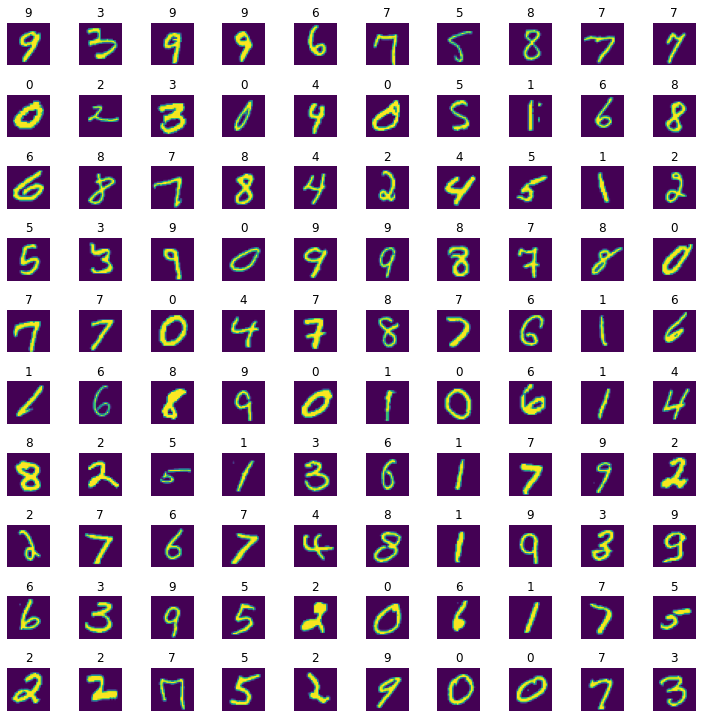

In [19]:
shownimg()

In [20]:
stat =  pd.DataFrame({'Label': np.array(train_labels), 'Set_type':'train'})
stat = stat.append(pd.DataFrame({'Label': np.array(validate_labels), 'Set_type':'validate'}),ignore_index=True)
stat = stat.append(pd.DataFrame({'Label': test_labels,'Set_type':'test'}),ignore_index=True)

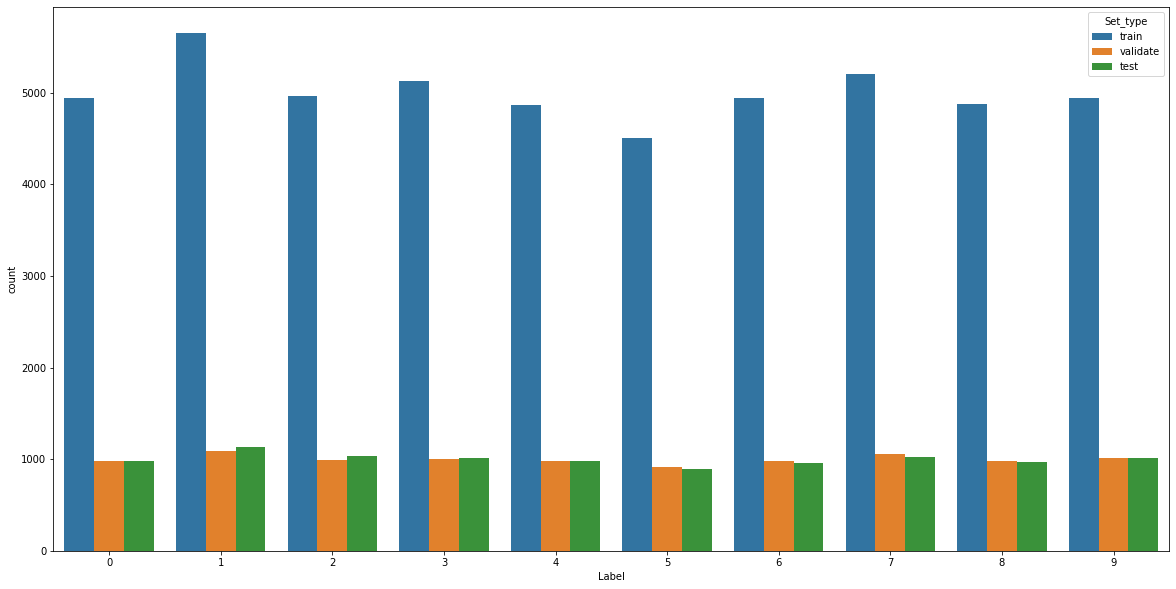

In [21]:
plt.figure(figsize=(20,10))
sns.countplot(x='Label',hue='Set_type',data=stat)

In [22]:
# class Net(nn.Module):
#     def __init__(self):
#       super(Net, self).__init__()
#       self.conv_layer = nn.Sequential(
#         # Conv Layer block 1
#         nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
#         nn.BatchNorm2d(32),
#         nn.ReLU(inplace=True),
#         nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
#         nn.ReLU(inplace=True),
#         nn.MaxPool2d(kernel_size=2, stride=2),

#         # Conv Layer block 2
#         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
#         nn.BatchNorm2d(128),
#         nn.ReLU(inplace=True),
#         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
#         nn.ReLU(inplace=True),
#         nn.MaxPool2d(kernel_size=2, stride=2),
#         nn.Dropout2d(p=0.05),

#         # Conv Layer block 3
#         # nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
#         # nn.BatchNorm2d(256),
#         # nn.ReLU(inplace=True),
#         # nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
#         # nn.ReLU(inplace=True),
#         # nn.MaxPool2d(kernel_size=2, stride=2),
#       )

#       self.fc_layer = nn.Sequential(
#         nn.Dropout(p=0.1),
#         nn.Linear(7*7*128, 1024),
#         nn.ReLU(inplace=True),
#         nn.Linear(1024, 512),
#         nn.ReLU(inplace=True),
#         nn.Dropout(p=0.1),
#         nn.Linear(512, 10)
#       )
#     def forward(self, x):
#       # conv layers
#       x = self.conv_layer(x)    
#       # flatten
#       x = x.view(x.size(0), -1)    
#       # fc layer
#       x = self.fc_layer(x)
#       return x

In [23]:
class Net(nn.Module):
   def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=64,kernel_size=3, padding=1)
      self.conv2 = nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3, padding=1)
      self.fc1 = nn.Linear(7*7*128, 1024)
      self.fc2 = nn.Linear(1024, 10)
      
   def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x,kernel_size= 2,stride= 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x,kernel_size= 2,stride= 2)
      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [24]:
criterion = nn.CrossEntropyLoss()
train_losses, train_acces = [], []
val_losses, val_acces = [], []

In [25]:
def calculate_loss_accuracy(network, device, dataloader, mode=""):
  running_loss = 0
  correct = 0
  number_of_data = 0
  network = network.to(device)
  network.eval()
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(dataloader):
      data, target = data.to(device), target.to(device)
      output = network(data)
      pred = torch.argmax(output, dim=1)
      correct += (pred==target).sum().item()

      loss = criterion(output, target)
      running_loss += loss.item()
      number_of_data += len(data)

      if mode == 'test':
        wrong_id = (pred!=target.view_as(pred)).nonzero()[:,0]
        fig = plt.figure(figsize=(10,10))
        for i,v in enumerate(wrong_id):
          ax = fig.add_subplot(2,10,i+1)
          ax.imshow(torch.squeeze(data[v].cpu()).numpy())
          ax.axis('off')
          ax.set_title((
                target[v].cpu().item(), 
                pred[v].cpu().item()
          ))
        fig.tight_layout()
    accuracy = correct/number_of_data
    loss = running_loss/len(dataloader)
    print("Number of batches: ", len(dataloader))
    print("Correct: {} On {} - Accuracy: {:.4f}".format(correct, number_of_data,accuracy))
    print("Loss over whole dataset: {:.4f}".format(loss))
  return accuracy, loss


In [26]:
# calculate_loss_accuracy(network, device, testloader)

In [27]:
def fit(network, trainloader, validateloader, opts):
  # best_val_loss = float('Inf')
  learning_rate, momentum, weight_decay, n_epochs = opts['learning_rate'], opts['momentum'], opts['weight_decay'], opts['n_epochs']
  best_val_accuracy = 0
  counter = 0
  early_stop = 20
  criterion = nn.CrossEntropyLoss()
  device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

  for epoch in range(1, n_epochs + 1):
    if epoch%50 == 0:
      learning_rate /=10
    learning_rates.append(learning_rate)
    print('Epoch {} - Learning rate: {}'.format(epoch, learning_rate))
    optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
    epoch_start_time = time.time()
    network.train()
    train_accuracy, train_loss = 0, 0

    for batch_idx, (data, target) in enumerate(trainloader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      pred = torch.argmax(output, dim=1)
      train_loss += loss.item()
      train_accuracy += (pred==target).sum().item()
      loss.backward()
      optimizer.step()
    epoch_times.append(time.time() - epoch_start_time)
    #evaluate epoch
    val_accuracy, val_loss = calculate_loss_accuracy(network, device, validateloader)
    # train_accuracy, train_loss = calculate_loss_accuracy(network, device, trainloader)
    train_accuracy /=50000
    train_loss /=len(trainloader)
    print("==========================================================================================================================")
    print("Epoch {}/{} - Train accuracy: {:.4f} - Train loss: {:.4f} - Validate accuracy: {:.4f} - Validate loss: {:.4f}".format(
        epoch, n_epochs, train_accuracy, train_loss, val_accuracy, val_loss
    ))
    print("==========================================================================================================================")
    train_losses.append(train_loss)
    train_acces.append(train_accuracy)
    val_losses.append(val_loss)
    val_acces.append(val_accuracy)

    #Save best network
    # if val_losses[-1] < best_val_loss:
      # best_val_loss = val_losses[-1]
    if val_acces[-1] > best_val_accuracy:
      best_val_accuracy = val_acces[-1]
      counter = 0
      torch.save(network.state_dict(),'checkpoint.pth')
    else:
      counter += 1
      print("***************************************************************************")
      # print('Validation loss has not improved from: {:.4f} - Count: {}'.format(best_val_loss, counter))
      print('Validation accuracy has not improved from: {:.4f} - Count: {}'.format(best_val_accuracy, counter))
      print("***************************************************************************")
      # if counter > early_stop:
        # print("Early Stopping!")
  network.load_state_dict(torch.load('checkpoint.pth'))
        # break

In [28]:
def predict(network, dataloader):
  return 1

In [29]:
network = Net()
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
network = network.to(device)
opts = {
    "n_epochs": 300,
    "learning_rate": 0.1,
    "momentum": 0.9,
    "weight_decay": 5e-4
}
train_losses, train_acces = [], []
val_losses, val_acces = [], []
epoch_times = []
learning_rates = []
fit(network, trainloader, validloader, opts)

Epoch 1 - Learning rate: 0.1
Number of batches:  79
Correct: 9611 On 10000 - Accuracy: 0.9611
Loss over whole dataset: 0.1277
Epoch 1/300 - Train accuracy: 0.8961 - Train loss: 0.3343 - Validate accuracy: 0.9611 - Validate loss: 0.1277
Epoch 2 - Learning rate: 0.1
Number of batches:  79
Correct: 9714 On 10000 - Accuracy: 0.9714
Loss over whole dataset: 0.0948
Epoch 2/300 - Train accuracy: 0.9668 - Train loss: 0.1072 - Validate accuracy: 0.9714 - Validate loss: 0.0948
Epoch 3 - Learning rate: 0.1
Number of batches:  79
Correct: 9738 On 10000 - Accuracy: 0.9738
Loss over whole dataset: 0.0881
Epoch 3/300 - Train accuracy: 0.9726 - Train loss: 0.0870 - Validate accuracy: 0.9738 - Validate loss: 0.0881
Epoch 4 - Learning rate: 0.1
Number of batches:  79
Correct: 9772 On 10000 - Accuracy: 0.9772
Loss over whole dataset: 0.0751
Epoch 4/300 - Train accuracy: 0.9751 - Train loss: 0.0792 - Validate accuracy: 0.9772 - Validate loss: 0.0751
Epoch 5 - Learning rate: 0.1
Number of batches:  79
Corr

In [30]:
summary(network,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
            Conv2d-2          [-1, 128, 14, 14]          73,856
            Linear-3                 [-1, 1024]       6,423,552
            Linear-4                   [-1, 10]          10,250
Total params: 6,508,298
Trainable params: 6,508,298
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.58
Params size (MB): 24.83
Estimated Total Size (MB): 25.41
----------------------------------------------------------------


In [31]:
calculate_loss_accuracy(network, device, validloader)

Number of batches:  79
Correct: 9898 On 10000 - Accuracy: 0.9898
Loss over whole dataset: 0.0317


(0.9898, 0.03173063996894863)

In [32]:
calculate_loss_accuracy(network, device, testloader)

Number of batches:  79
Correct: 9931 On 10000 - Accuracy: 0.9931
Loss over whole dataset: 0.0209


(0.9931, 0.02091913398346404)

In [33]:
logs = pd.DataFrame({
    "Train_loss": np.array(train_losses),
    "Validate_loss": np.array(val_losses),
    "Train_accuracy": np.array(train_acces),
    "Validate_accuracy": np.array(val_acces),
    "Epoch_time": np.array(epoch_times),
    "Learning_rate": np.array(learning_rates)
    })

In [34]:
logs['n_epoch'] = np.array([x for x in range(1, logs.shape[0]+1)])

In [35]:
logs

,Train_loss,Validate_loss,Train_accuracy,Validate_accuracy,Epoch_time,Learning_rate,n_epoch
0,0.334315,0.127713,0.89612,0.9611,13.147085,1.000000e-01,1
1,0.107248,0.094808,0.96684,0.9714,12.404432,1.000000e-01,2
2,0.086980,0.088123,0.97260,0.9738,12.547644,1.000000e-01,3
3,0.079164,0.075099,0.97506,0.9772,12.489151,1.000000e-01,4
4,0.073305,0.081615,0.97738,0.9766,13.336200,1.000000e-01,5
...,...,...,...,...,...,...,...
295,0.008031,0.033811,0.99806,0.9886,13.137720,1.000000e-06,296
296,0.008380,0.031460,0.99812,0.9900,12.606662,1.000000e-06,297
297,0.008422,0.032496,0.99814,0.9910,12.413411,1.000000e-06,298
298,0.008728,0.035014,0.99784,0.9902,12.453427,1.000000e-06,299


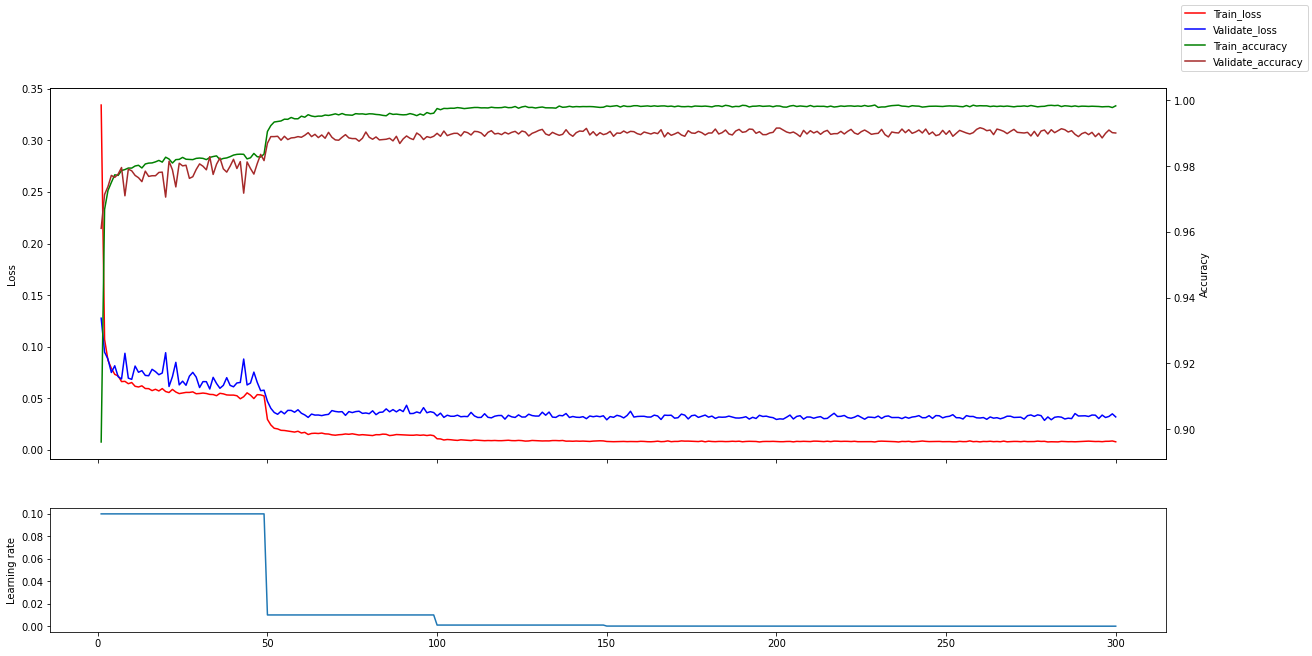

In [36]:
figure, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize=(20,10))
tr_loss = ax1.plot(logs['n_epoch'], logs['Train_loss'], label='Train_loss', color='red')
va_loss = ax1.plot(logs['n_epoch'], logs['Validate_loss'], label='Validate_loss', color='blue')
ax1.set_ylabel('Loss')
ax12 = ax1.twinx()
ax12.set_ylabel('Accuracy')
tr_acc = ax12.plot(logs['n_epoch'], logs['Train_accuracy'], label='Train_accuracy', color='green')
va_acc = ax12.plot(logs['n_epoch'], logs['Validate_accuracy'], label='Validate_accuracy', color='brown')
ax2.plot(logs['n_epoch'], logs['Learning_rate'])
ax2.set_ylabel('Learning rate')
leds = tr_loss + va_loss + tr_acc + va_acc
labs = [l.get_label() for l in leds]
figure.legend(leds, labs, loc="upper right")

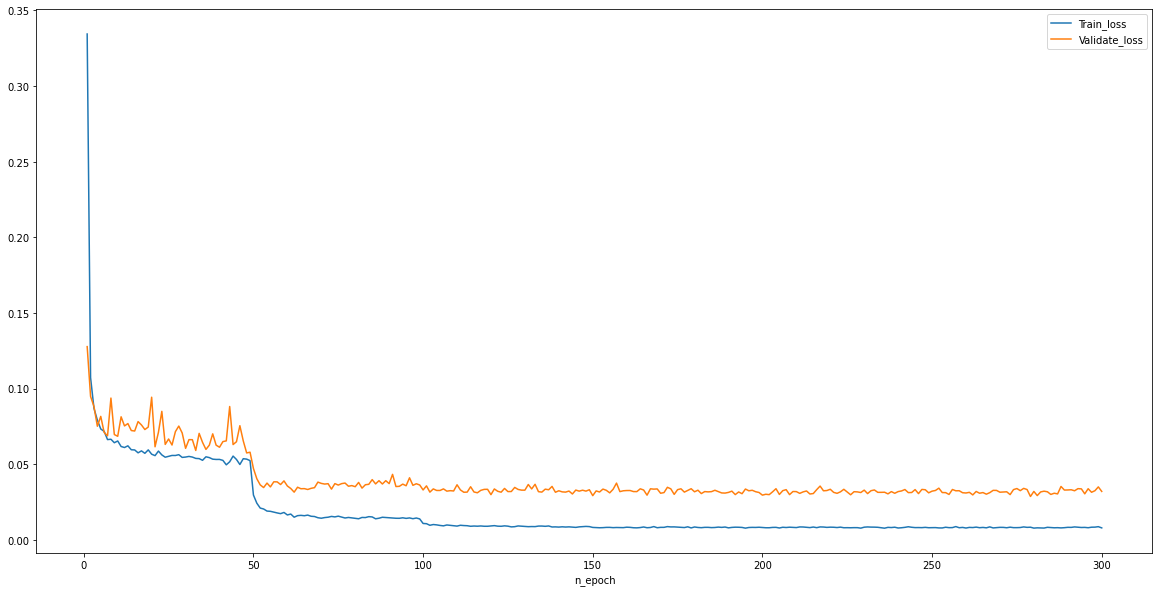

In [37]:
logs.plot(x="n_epoch", y=["Train_loss","Validate_loss"], figsize=(20,10))

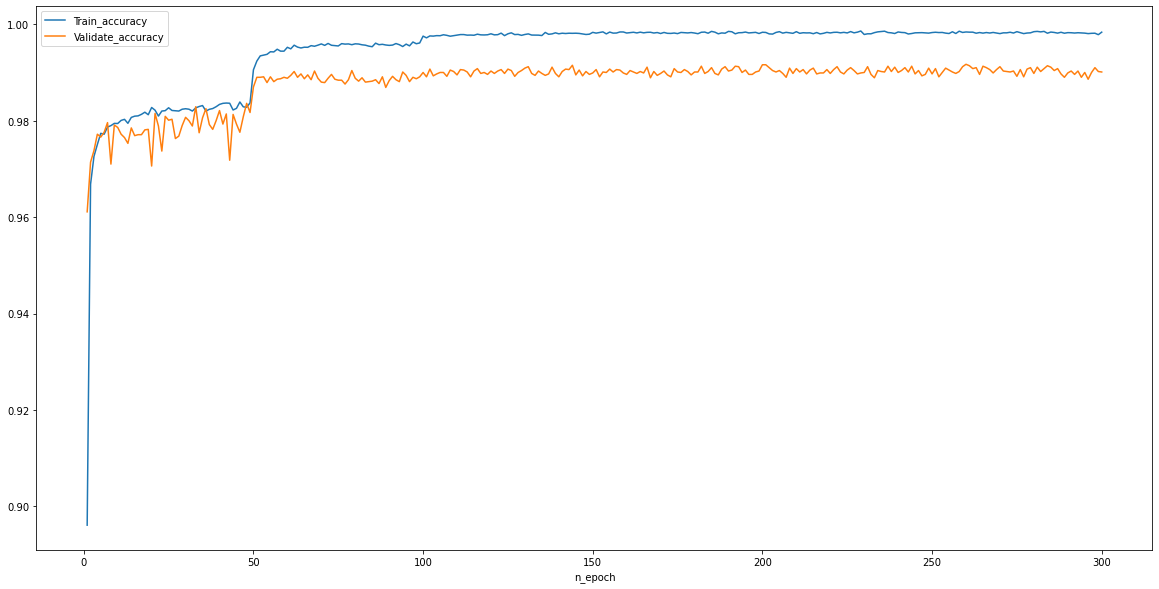

In [38]:
logs.plot(x="n_epoch", y=["Train_accuracy","Validate_accuracy"],figsize=(20,10))

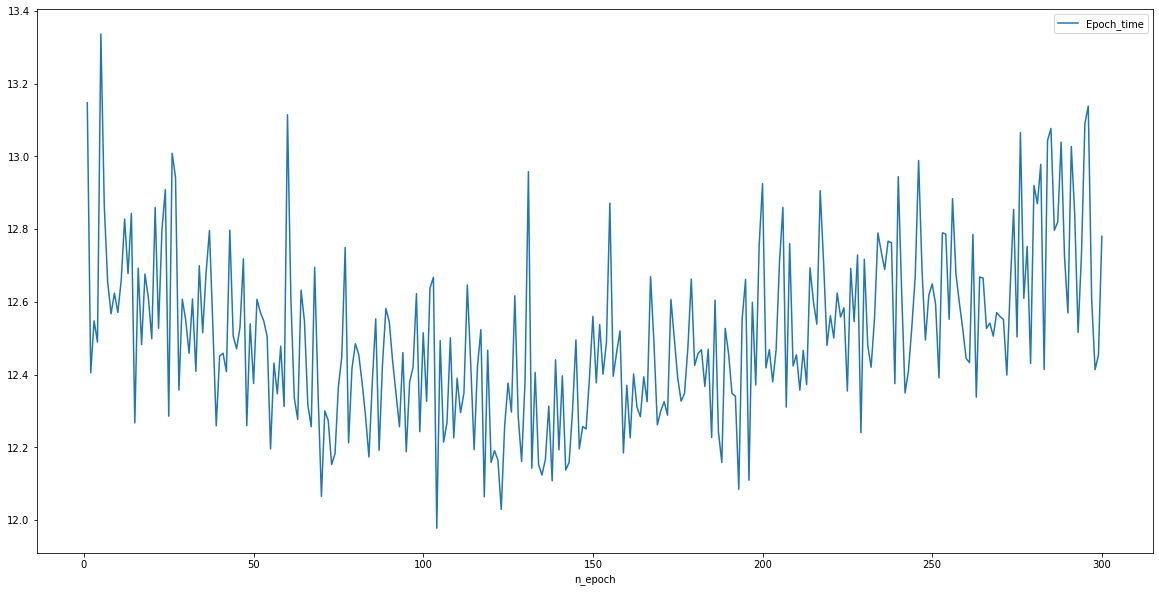

In [39]:
logs.plot(x="n_epoch", y="Epoch_time", figsize=(20,10))

In [40]:
def confusion_matrix(net, device, dataloader):
  classes = dataloader.dataset.classes
  matrix = np.zeros((len(classes), len(classes)))
  net = net.to(device)
  net.eval()
  with torch.no_grad():
    for _, (data, target) in enumerate(dataloader):
      data, target = data.to(device), target.to(device)
      output = net(data)
      preds = torch.argmax(output, dim=1)
      for idx, pred in enumerate(preds):
        actual = target[idx]
        matrix[pred, actual] += 1
  con_mat = pd.DataFrame(data=matrix, columns=classes, index=classes)
  for i, v in enumerate(classes):
    con_mat.loc[v,'total_predict'] = con_mat.loc[v,:].sum()
    con_mat.loc['total_actual',v] = con_mat.loc[:,v].sum()
  return con_mat.fillna(0).astype('int64')

In [41]:
# def confusion_matrix2(net, device, dataloader):
#   preds, targets = [], []
#   net.eval()
#   with torch.no_grad():
#     for _, (data, target) in enumerate(dataloader):
#       data, target = data.to(device), target.to(device)
#       output = net(data)
#       pred = torch.argmax(output, dim=1)
#       preds.extend(pred.cpu().numpy())
#       targets.extend(target.cpu().numpy())
#   return conf_mat(targets, preds)

In [42]:
c_m = confusion_matrix(network, device, testloader)

In [43]:
c_m

,0 - zero,1 - one,2 - two,3 - three,4 - four,5 - five,6 - six,7 - seven,8 - eight,9 - nine,total_predict
0 - zero,977,0,0,0,0,2,4,0,1,0,984
1 - one,1,1133,0,0,0,0,2,2,0,0,1138
2 - two,0,0,1023,1,0,5,1,1,1,0,1032
3 - three,0,0,0,1006,0,4,0,0,0,0,1010
4 - four,0,0,1,0,978,0,2,0,0,6,987
5 - five,0,0,1,3,0,878,1,1,1,3,888
6 - six,0,2,4,0,1,2,947,0,0,0,956
7 - seven,1,0,3,0,0,1,0,1022,0,2,1029
8 - eight,0,0,0,0,0,0,1,1,970,1,973
9 - nine,1,0,0,0,3,0,0,1,1,997,1003


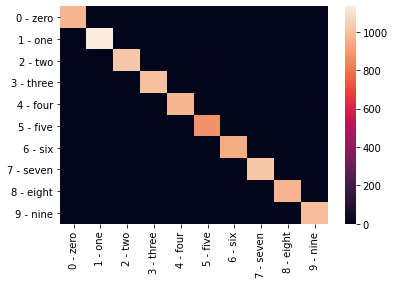

In [44]:
sns.heatmap(data=c_m.loc[trainset.classes, trainset.classes]) 

In [45]:
def stat_result(classes, confusion_matrix):
  columns = ['Class', 'Precision', 'Recall', 'F1_score']
  stat_matrix = pd.DataFrame(columns=columns, data=np.zeros((len(classes), len(columns))))
  for i, v in enumerate(classes):
    precision = confusion_matrix.iloc[i,i]/confusion_matrix.iloc[i, -1]
    recall    = confusion_matrix.iloc[i,i]/confusion_matrix.iloc[-1, i]
    stat_matrix.loc[i, 'Class'] = v
    stat_matrix.loc[i, 'Precision'] = precision
    stat_matrix.loc[i, 'Recall'] = recall
    stat_matrix.loc[i, 'F1_score'] = 2*precision*recall/(precision+recall)
  return stat_matrix

In [46]:
st = stat_result(trainset.classes, c_m)

In [47]:
st

,Class,Precision,Recall,F1_score
0,0 - zero,0.992886,0.996939,0.994908
1,1 - one,0.995606,0.998238,0.996920
2,2 - two,0.991279,0.991279,0.991279
3,3 - three,0.996040,0.996040,0.996040
4,4 - four,0.990881,0.995927,0.993398
5,5 - five,0.988739,0.984305,0.986517
6,6 - six,0.990586,0.988518,0.989551
7,7 - seven,0.993197,0.994163,0.993680
8,8 - eight,0.996917,0.995893,0.996405
9,9 - nine,0.994018,0.988107,0.991054


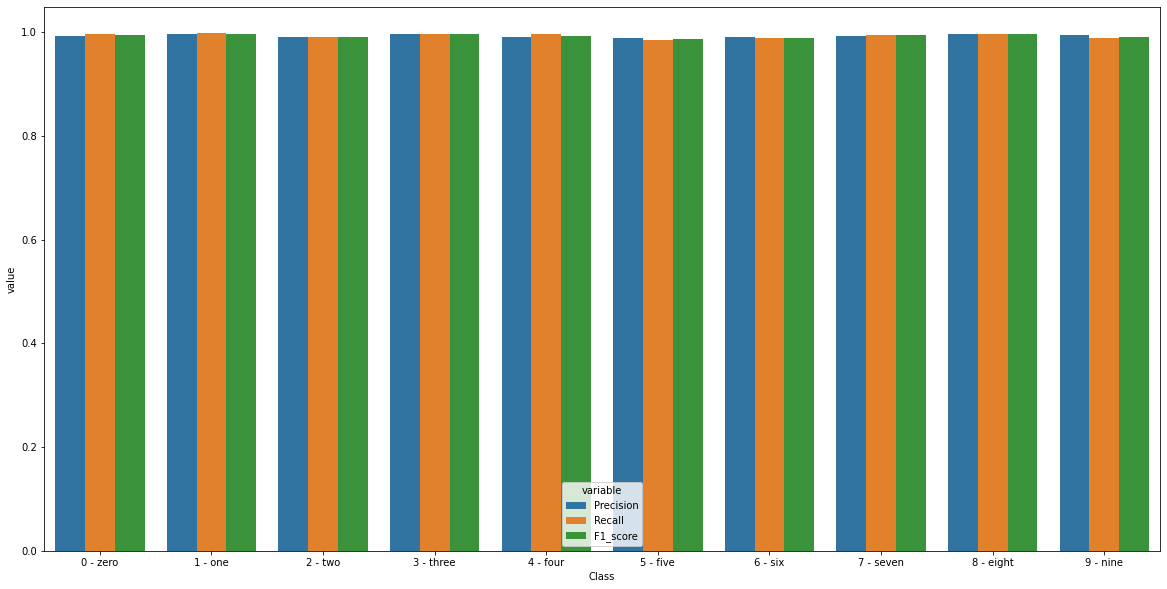

In [48]:
plt.figure(figsize=(20,10))
sns.barplot(data=pd.melt(st, id_vars = 'Class', value_vars=['Precision', 'Recall', 'F1_score']), x='Class', y='value', hue='variable')